## CBAM (Convolutional Block Attention Module) Autoencoder Model - BD67 Dataset

ChannelGate + SpatialGate

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/attention_modules.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/backbones.py

os.chdir('/content')
print("Current working directory", os.getcwd())

Current working directory /content


In [4]:
from utils import vision
from utils import utils
from utils import losses
from utils import models
from utils import backbones
from utils.attention_modules import Conv2DLayerBN, Conv2DLayerRes, ChannelGate, SpatialGate, CBAM

### Experiment Setup Start

In [5]:
# Create experiment folder
EXPERIMENT_NAME = 'CBAM_ConvAE_Model'
EXPERIMENT_SAVE_DIR = os.path.join('/content/drive/MyDrive/MASTER/Master_Thesis/Experiments', EXPERIMENT_NAME)

In [6]:
experiment = {
    'TYPE': 'test',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'CPU', 'GPU' or 'TPU'

    # Input data
    'DATASET': 'BD67_Dataset',
    'IMAGE_SIZE': (256, 256),
    'INPUT_SHAPE': (256, 256, 3),
    'PATCH_SIZE': 256,
    'VALID_SIZE': 0.1,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': True,       # Apply data augmentation
    'DATA_AUG_POWER': 2,    # Data augmentation power: How many times data
     # augmentation will be applied to the whole dataset. default 1

    # Model
    'BACKBONE': 'CBAM_ConvAE',   # 'custom', 'VGG16', 'VGG19', 'ResNet50' - default 'custom'
    'DECODER_ATTENTION': True,   # If True, CBAM attention layer in both encoder and decoder layer
    'REDUCTION_RATIO': 16,       # CBAM layer reduction ratio
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 16,            # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 200,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 1e-4,
    # set latent dim - shape: (LATENT_DIM, 1) - default 200
    'LATENT_DIM': 256,

    # Loss
    'RECONS_LOSS': 'MSE',  # Reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'PERCEPTUAL_LAYERS': [35,77,139,150],    # 'conv2_block3_3_conv', 'conv3_block4_3_conv', 'conv4_block6_3_conv', 'conv5_block1_3_conv'
    'PERCEP_LOSS_MODEL': 'ResNet50', # 'custom', 'VGG16', 'VGG19', 'ResNet50' - default 'VGG16'
    'PERP_LOSS_LAMBDA': 1,    # Perceptual loss coeff
    'MSE_LOSS_LAMBDA': 0.5,     # MSE coeff
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value

    # Save model
    'SAVE_WEIGHTS_PER_EPOCH': 50,  # Checkpoints
}

In [7]:
if experiment['TYPE'] == 'train':
    assert(EXPERIMENT_NAME != '...')
    # Create experiment folder
    os.makedirs(EXPERIMENT_SAVE_DIR, exist_ok=True)

    # Model checkpoints will be save in exp_save_dir
    exp_save_dir = utils.create_experimental_output(experiment, EXPERIMENT_SAVE_DIR)

    TRAINING_WEIGHT_DIR = os.path.join(exp_save_dir, 'training_weights')
    # Create folder for checkpoints (training weights)
    os.makedirs(TRAINING_WEIGHT_DIR, exist_ok=True)
else:  # test mode
    # Set experiment save directory and training weight directory manually
    exp_save_dir = '/content/drive/MyDrive/MASTER/Master_Thesis/Experiments/CBAM_ConvAE_Model/experiment_2'
    TRAINING_WEIGHT_DIR = os.path.join(exp_save_dir, 'training_weights')

In [8]:
print(f"...Experiment {exp_save_dir.split('experiment_')[1]} was initialized...")
print(f"Experiment directory: {EXPERIMENT_SAVE_DIR}")
print(f"Training weights save directory: {TRAINING_WEIGHT_DIR}")

...Experiment 2 was initialized...
Experiment directory: /content/drive/MyDrive/MASTER/Master_Thesis/Experiments/CBAM_ConvAE_Model
Training weights save directory: /content/drive/MyDrive/MASTER/Master_Thesis/Experiments/CBAM_ConvAE_Model/experiment_2/training_weights


### Experiment Setup End

In [9]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'
TFRECORD_TRAIN_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images.tfrecords'
TFRECORD_TEST_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images_test.tfrecords'
BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/partitioned/grid_0')
BD67_NORMAL_FRONT_ROTATED_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/rotated_images/partitioned/grid_0')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front/partitioned/grid_0')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')
REFERENCE_BD67_NORMAL_FRONT = os.path.join(DATASET_PATH, 'defect_free/Front/reference_img')

In [10]:
img_files = utils.get_image_file_list("/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defect_free/Front/cropped", 'png')
rotated_img_files = utils.get_image_file_list("/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defect_free/Front/rotated_images/cropped", 'png')
all_img_files = img_files + rotated_img_files
test_img_files = utils.get_image_file_list("/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defected/Front/cropped", 'png')

print("Number of flat image files: ", len(img_files))
print("Number of rotated image files: ", len(rotated_img_files))
print("Number of all image files: ", len(all_img_files))

Number of flat image files:  110
Number of rotated image files:  105
Number of all image files:  215


In [11]:
all_img_files = img_files

In [12]:
test_img = utils.load_images(all_img_files[0], scl=True)

grid_width = test_img.shape[1] // experiment['PATCH_SIZE']
grid_height = test_img.shape[0] // experiment['PATCH_SIZE']

In [13]:
all_imgs = utils.patchify_images(all_img_files, patch_size=experiment['PATCH_SIZE'])
all_imgs = utils.cvt_color_BGR2RGB(all_imgs)

['absl-py', 'aiohttp', 'aiosignal', 'alabaster', 'albumentations', 'altair', 'anyio', 'appdirs', 'argon2-cffi', 'argon2-cffi-bindings', 'array-record', 'arviz', 'astropy', 'astunparse', 'async-timeout', 'atpublic', 'attrs', 'audioread', 'autograd', 'Babel', 'backcall', 'beautifulsoup4', 'bidict', 'bigframes', 'bleach', 'blinker', 'blis', 'blosc2', 'bokeh', 'bqplot', 'branca', 'build', 'CacheControl', 'cachetools', 'catalogue', 'certifi', 'cffi', 'chardet', 'charset-normalizer', 'chex', 'click', 'click-plugins', 'cligj', 'cloudpickle', 'cmake', 'cmdstanpy', 'colorcet', 'colorlover', 'colour', 'community', 'confection', 'cons', 'contextlib2', 'contourpy', 'cryptography', 'cufflinks', 'cupy-cuda12x', 'cvxopt', 'cvxpy', 'cycler', 'cymem', 'Cython', 'dask', 'datascience', 'db-dtypes', 'dbus-python', 'debugpy', 'decorator', 'defusedxml', 'diskcache', 'distributed', 'distro', 'dlib', 'dm-tree', 'docutils', 'dopamine-rl', 'duckdb', 'earthengine-api', 'easydict', 'ecos', 'editdistance', 'eerepr

(-0.5, 1791.5, 1279.5, -0.5)

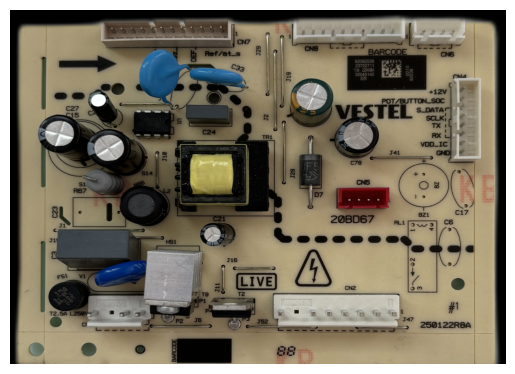

In [14]:
res = utils.unpatchify_img(all_imgs[:(grid_width*grid_height)], grid=(grid_width,grid_height))
plt.imshow(res)
plt.axis('off')

Use all of the partitioned images together

In [15]:
#num_grids = 6
#all_img_files = []
#
#for grid in range(num_grids):
#    directory = BD67_NORMAL_FRONT_PATH[:-1] + str(grid)
#    img_files = utils.get_image_file_list(directory, 'png')
#    all_img_files += img_files

Data Augmentation Layer

In [16]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

if experiment['DATA_AUG']:
    # Setup data augmentation
    data_aug_layer = Sequential([
      #preprocessing.RandomFlip("horizontal_and_vertical"), # randomly flip images on horizontal/vertical edge
      #preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
      #preprocessing.RandomZoom(0.2), # randomly zoom into an image
      tf.keras.layers.RandomBrightness(factor=0.2, value_range=[0.0, 1.0], seed=None),
      # value_range parameter should be [0.0, 1.0] for RandomBrightness
      # if images were scaled before, default value is [0,255]
      tf.keras.layers.RandomContrast(0.2, seed=None),
      #tf.keras.layers.RandomCrop(256, 256, seed=None), Error - Image size changes
      #preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
      #preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
      #preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
    ], name="data_aug_layer")
else:
    data_aug_layer = None

ResNet50 Network Convolutional layer determination for Perceptual Loss.

Note: The earlier layers of a deep CNN capture low-level features (such as edges and textures), while later layers capture high-level semantic information. A common choice is to use the activations from the last convolutional block or several last blocks of the network. Eg '`conv5_block1_1_conv`', '`conv5_block1_2_conv`', '`conv5_block1_3_conv`'.

In [17]:
'''
perceptual_loss_layers = ['conv2_block3_3_conv', 'conv3_block4_3_conv', 'conv4_block6_3_conv', 'conv5_block1_3_conv']

for ix, layer in enumerate(perp_model.layers):
    if str(layer.name) in perceptual_loss_layers:
        print(f"{ix}. layer: {layer.name}")
'''
# Output
# 35. layer: conv2_block3_3_conv
# 77. layer: conv3_block4_3_conv
# 139. layer: conv4_block6_3_conv
# 150. layer: conv5_block1_3_conv

'\nperceptual_loss_layers = [\'conv2_block3_3_conv\', \'conv3_block4_3_conv\', \'conv4_block6_3_conv\', \'conv5_block1_3_conv\']\n\nfor ix, layer in enumerate(perp_model.layers):\n    if str(layer.name) in perceptual_loss_layers:\n        print(f"{ix}. layer: {layer.name}")\n'

In [18]:
#train_dataset = utils.create_dataset_pipeline(all_img_files, batch_size=experiment['BATCH_SIZE'], img_size=experiment['IMAGE_SIZE'], scl=True, shuffle=True, num_channels=3, rot=utils.ROT_0, duplicate=False, aug_layer=data_aug_layer, data_aug_power=3, accelerator='GPU')
del all_imgs

dataset = tf.data.Dataset.from_tensor_slices(tf.cast(utils.cvt_color_BGR2RGB(utils.patchify_images(all_img_files, patch_size=experiment['PATCH_SIZE'])).numpy(), tf.float32) / 255.)

dataset = dataset.shuffle(len(dataset))

dataset = dataset.batch(experiment['BATCH_SIZE'])
dataset = dataset.cache()
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

train_dataset = dataset
del dataset

In [19]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [20]:
print("Number of batches to be trained: ", len(train_dataset))

Number of batches to be trained:  241


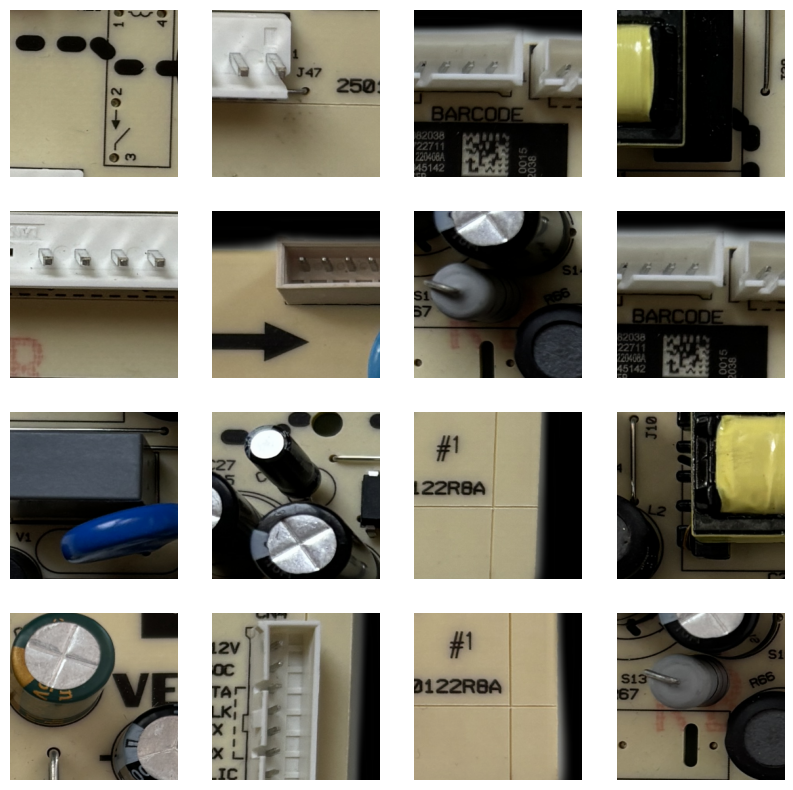

In [21]:
vision.show_image_samples_from_batch(train_dataset)

In [22]:
custom_model = backbones.build_CBAMConvAEModelV1(input_shape=experiment['INPUT_SHAPE'],
                                                 latent_dim=experiment['LATENT_DIM'],
                                                 reduction_ratio=experiment['REDUCTION_RATIO'],
                                                 attention_for_decoder=experiment['DECODER_ATTENTION'])

custom_model.summary()

Model: "conv_ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_block_0 (Conv2DLaye  (None, 128, 128, 32)      2560      
 rBN)                                                            
                                                                 
 cbam (CBAM)                 (None, 128, 128, 32)      265       
                                                                 
 conv2d_block_1 (Conv2DLaye  (None, 64, 64, 64)        51520     
 rBN)                                                            
                                                                 
 cbam_1 (CBAM)               (None, 64, 64, 64)        683       
                                                                 
 conv2d_block_2 (Conv2DLaye  (None, 32, 32, 128)     

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # All layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  print("test_input.shape: ", test_input.shape)
  print("predictions.shape: ", predictions.shape)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.array((predictions[i, :, :, :] * 255)).astype(np.uint8))
    plt.axis('off')
    if i >= 15:
      break

  #plt.savefig(experiment['IMGS_DIR'] + '/image_at_epoch_{:d}.png'.format(epoch))
  plt.show()

In [24]:
if experiment['ACCELERATOR'] != 'TPU':
  @tf.function
  def train_step(images):
      with tf.GradientTape() as tape:
          generated_images = custom_model(images, training=True)
          #loss = custom_model.compute_mse_perceptual(images, generated_images)
          loss = custom_model.loss(images, generated_images)

      gradients = tape.gradient(loss, custom_model.trainable_variables)
      custom_model.optimizer.apply_gradients(zip(gradients, custom_model.trainable_variables))

      return loss

In [25]:
from IPython import display
import time

if experiment['ACCELERATOR'] != 'TPU':
  def train(dataset, epochs):
      loss_hist = []  # Keep loss history
      for epoch in range(epochs):
          start = time.time()
          for image_batch in dataset:
              loss = train_step(image_batch)

          loss_hist.append(loss)   # Add loss value to the loss history after each epoch
          print("loss: ", tf.reduce_mean(loss).numpy())

          # Save the model every experiment['SAVE_WEIGHTS_PER_EPOCH'] epochs
          if (epoch + 1) % experiment['SAVE_WEIGHTS_PER_EPOCH'] == 0:
            seed = image_batch[:experiment['BATCH_SIZE']]
            display.clear_output(wait=True)
            generate_and_save_images(custom_model,
                                      epoch + 1,
                                      seed)

            # Save checkpoints
            utils.save_experiment_checkpoints([custom_model], epoch=(epoch+1), save_dir=TRAINING_WEIGHT_DIR)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

      # Generate after the final epoch
      display.clear_output(wait=True)
      generate_and_save_images(custom_model,
                              epochs,
                              seed)

      #utils.remove_training_weights_except_last_epoch(TRAINING_WEIGHT_DIR)  # Remove weights except last epoch's

      return loss_hist

In [26]:
if experiment['TYPE'] == 'train':
    custom_model.compile(loss=tf.keras.losses.mean_squared_error,
                         optimizer=tf.keras.optimizers.Adam(learning_rate=experiment['LEARNING_RATE']))
    # Start training the model with previously trained weights
    #utils.load_model_experiment_weights([custom_model], epoch=100, load_dir='/content/drive/MyDrive/MASTER/Master_Thesis/Experiments/CBAM_ConvAE_Model/experiment_1/training_weights')
    custom_model_hist = train(train_dataset, experiment['EPOCHS'])
else:  # test mode
    # Set load weight epoch number manually
    utils.load_model_experiment_weights([custom_model], epoch=experiment['EPOCHS'], load_dir=TRAINING_WEIGHT_DIR)

In [27]:
if experiment['TYPE'] == 'train':
    utils.remove_training_weights_except_last_epoch(TRAINING_WEIGHT_DIR)  # Remove weights except last epoch's

In [28]:
#if experiment['TYPE'] == 'train':
#    plt.plot(custom_model_hist)

In [29]:
def get_generated_image_batch(data):
    reconstructed_batch = None

    for image_batch in data:
      generated_batch = custom_model.predict(image_batch)

      if reconstructed_batch is None:
          reconstructed_batch = generated_batch
      else:
          reconstructed_batch = np.concatenate((reconstructed_batch, generated_batch))

      if reconstructed_batch.shape[0] > 5000:
          break

    return reconstructed_batch

In [30]:
generated_train_data = get_generated_image_batch(train_dataset.take(1))  # Use only first batch
generated_train_data.shape

1/1 [==============================] - 3s 3s/step


(16, 256, 256, 3)

In [31]:
def show_generated_images(image_batch):
  fig = plt.figure(figsize=(10, 10))
  for index, image in enumerate(image_batch):
    plt.subplot(4, 4, index + 1)
    plt.imshow(image)
    plt.axis('off')
    if index >= 15:
      break
  plt.show()

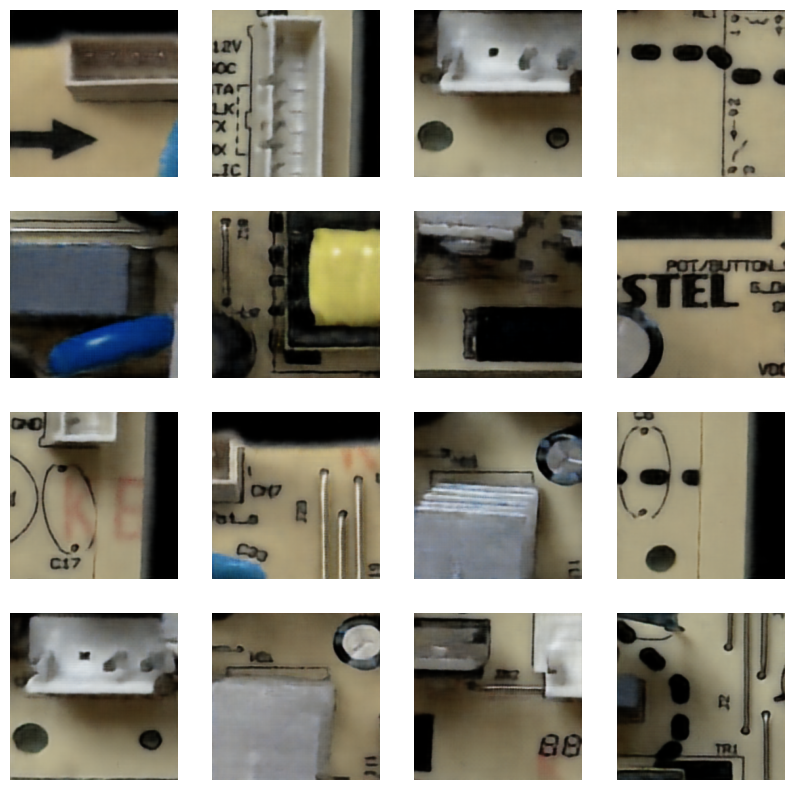

In [32]:
show_generated_images(generated_train_data)

In [33]:
#num_grids = 6
#test_img_files = []
#test_images = []
#
#for grid in range(num_grids):
#    directory = BD67_DEFECTED_FRONT_PATH[:-1] + str(grid)
#    img_files = utils.get_image_file_list(directory, 'png')
#    test_images.append(utils.load_and_prepare_images(img_files, img_size=experiment['IMAGE_SIZE'], scl=True))
#    test_img_files += img_files

In [34]:
print("Number of Test image files: ", len(test_img_files))

Number of Test image files:  23


In [35]:
test_img_files

test_imgs = utils.patchify_images(test_img_files, patch_size=experiment['PATCH_SIZE'])
test_imgs = utils.cvt_color_BGR2RGB(test_imgs)

In [36]:
#test_dataset = utils.create_dataset_pipeline(test_img_files, batch_size=experiment['BATCH_SIZE'], img_size=experiment['IMAGE_SIZE'], scl=True, shuffle=False, num_channels=3, rot=utils.ROT_0, aug_layer=None, data_aug_power=1, accelerator='GPU')

del test_imgs
dataset = tf.data.Dataset.from_tensor_slices(tf.cast(utils.cvt_color_BGR2RGB(utils.patchify_images(test_img_files, patch_size=experiment['PATCH_SIZE'])).numpy(), tf.float32) / 255.)

dataset = dataset.batch(experiment['BATCH_SIZE'])
dataset = dataset.cache()
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = dataset
del dataset

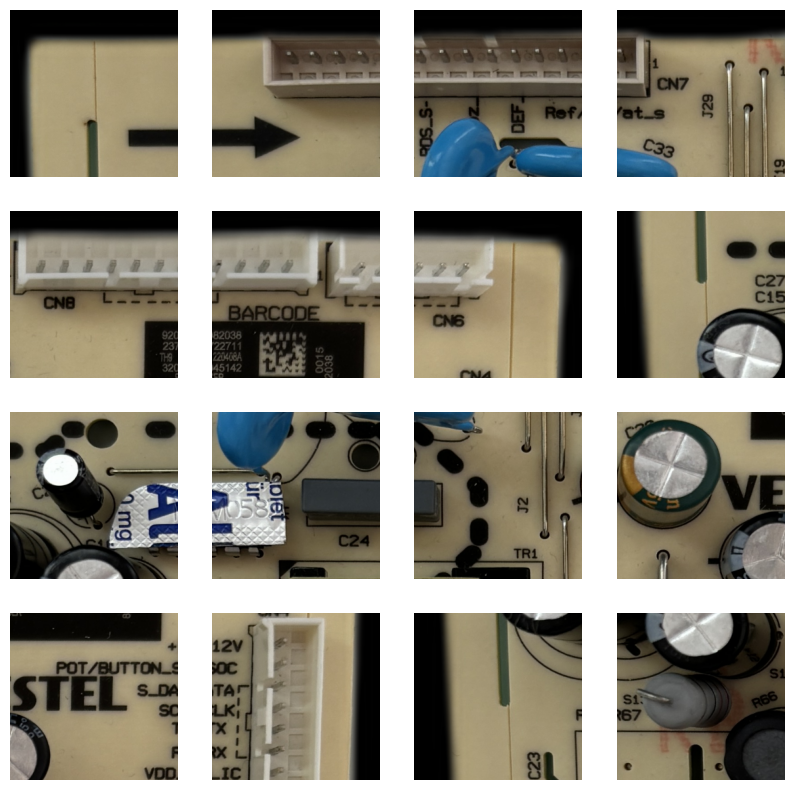

In [37]:
vision.show_image_samples_from_batch(test_dataset)

In [38]:
TEST_IMG_IX = 0

1/1 [==============================] - 0s 463ms/step


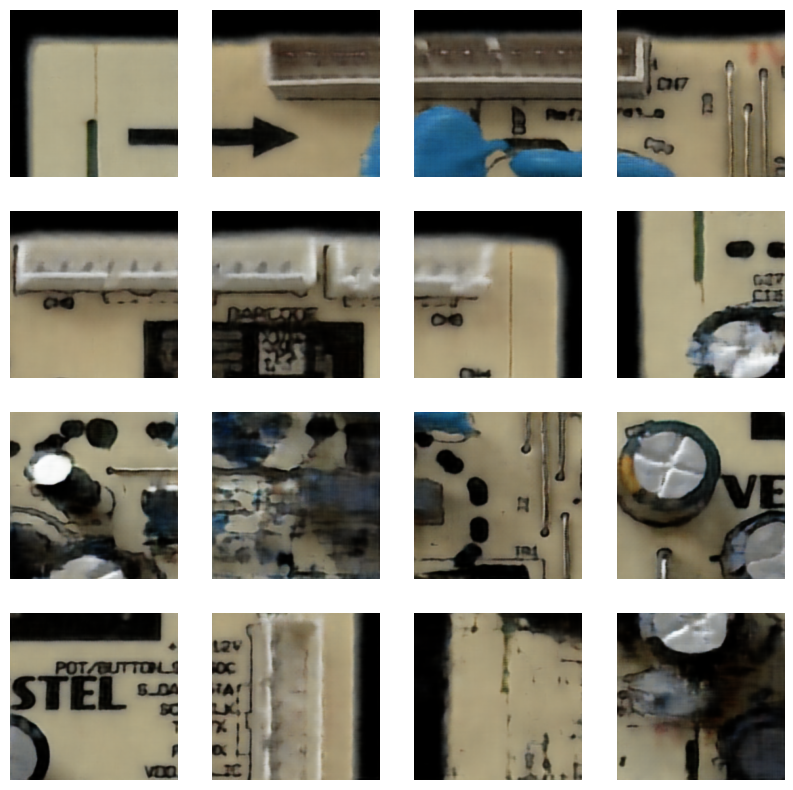

In [39]:
generated_test_data = get_generated_image_batch(test_dataset)

show_generated_images(generated_test_data)

(-0.5, 1791.5, 1279.5, -0.5)

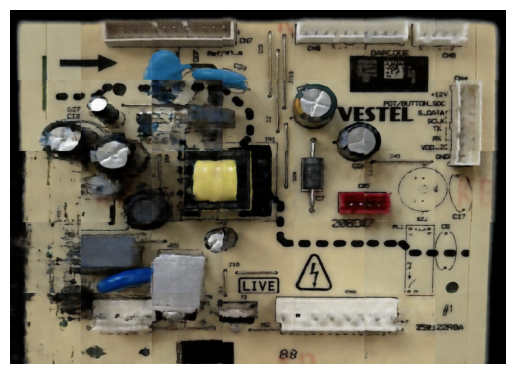

In [40]:
res = utils.unpatchify_img(generated_test_data[:(grid_width*grid_height)], grid=(grid_width,grid_height))
plt.imshow(res)
plt.axis('off')

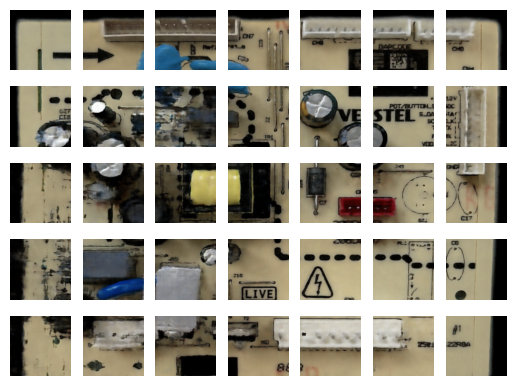

In [41]:
grid_starter = 0
partitioned_images = []

for ix in range(grid_width*grid_height):
  plt.subplot(grid_height, grid_width, (ix+1))
  plt.imshow(generated_test_data[grid_starter+TEST_IMG_IX])
  # Create partitioned images list to unpatchify
  partitioned_images.append(generated_test_data[grid_starter+TEST_IMG_IX])

  grid_starter += 1
  plt.axis('off')

plt.show()

In [42]:
def unpatchify_img(patches, grid):
  cols, rows = grid[0], grid[1]
  patch_list = []
  num_col_patches = 0

  for row_ix in range(rows):
    patch_list.append(patches[num_col_patches])
    for col_ix in range(cols-1):
      patch_list[row_ix] = np.concatenate((patch_list[row_ix], patches[num_col_patches+1+col_ix]), axis=1)
    num_col_patches += cols
    if row_ix == 0:
      image = patch_list[row_ix]
    else:
      image = np.concatenate((image, patch_list[row_ix]), axis=0)

  return image

In [43]:
generated_test_img = unpatchify_img(partitioned_images[:grid_width*grid_height], grid=(grid_width,grid_height))

(-0.5, 1791.5, 1279.5, -0.5)

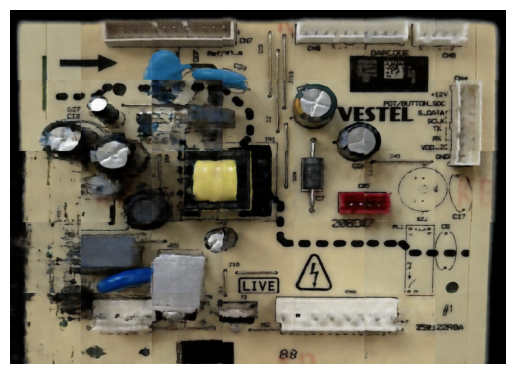

In [44]:
plt.imshow(generated_test_img)
plt.axis('off')

In [45]:
def display_pixel_wise_img_diff(img1_dir, img2_dir, threshold=None, verbose=0, channel=0, colorbar=True):
  # Load your two images using TensorFlow
  #image1 = tf.image.decode_image(tf.io.read_file(img1_dir))
  #image2 = tf.image.decode_image(tf.io.read_file(img2_dir))
  image1 = img1_dir
  image2 = img2_dir

  # Ensure both images have the same shape and data type
  image1 = tf.cast(image1, tf.float32)
  image2 = tf.cast(image2, tf.float32)

  # Compute pixel-wise absolute differences
  #diff = (tf.square(tf.math.pow(image2, 2) - tf.math.pow(image1, 2)))
  diff = tf.abs(image1 - image2)
  if verbose > 0:  print(f"Difference map shape: {diff.shape}")

  # Define a colormap (e.g., 'jet') and normalize the differences
  cmap = plt.get_cmap('jet')
  norm = plt.Normalize(vmin=0, vmax=tf.reduce_max(diff).numpy())
  norm_diff = norm(diff)
  if verbose > 0:
    print(f"Normalized difference map shape: {norm_diff.shape}")
    print(f"Normalized difference map min, avg, max value: ({np.min(norm_diff)}, {np.mean(norm_diff):.5f}, {np.max(norm_diff)})")

  colored_diff = cmap(norm_diff)
  if verbose > 0:  print(f"Colored difference map shape: {colored_diff.shape}")

  color_diff_plot = colored_diff[:, :, :,channel]

  if threshold != None:
    color_diff_plot[color_diff_plot < threshold] = 0.0

  # Display the color-coded difference map
  plt.imshow(color_diff_plot)
  if colorbar:
    plt.colorbar()
  plt.axis('off')
  plt.show()

In [46]:
test_batch = next(iter(test_dataset))

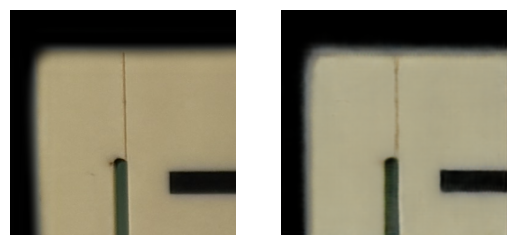

In [47]:
test_ix = TEST_IMG_IX

plt.subplot(1,2,1)
plt.imshow(test_batch[test_ix])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated_test_data[test_ix])
plt.axis('off')
plt.show()

Difference map shape: (256, 256, 3)
Normalized difference map shape: (256, 256, 3)
Normalized difference map min, avg, max value: (1.742243682656408e-08, 0.10086, 1.0)
Colored difference map shape: (256, 256, 3, 4)


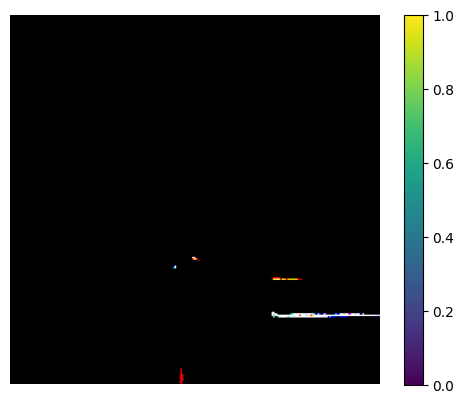

In [48]:
display_pixel_wise_img_diff(test_batch[test_ix], generated_test_data[test_ix], threshold=0.8, channel=0, verbose=1)

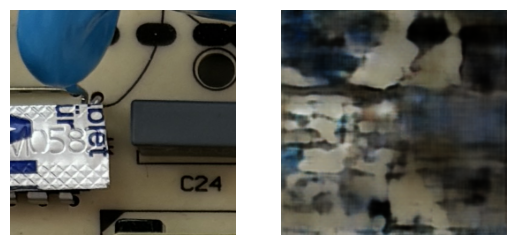

In [49]:
test_ix = TEST_IMG_IX

plt.subplot(1,2,1)
plt.imshow(test_batch[9+test_ix])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated_test_data[9+test_ix])
plt.axis('off')
plt.show()

Difference map shape: (256, 256, 3)
Normalized difference map shape: (256, 256, 3)
Normalized difference map min, avg, max value: (2.2600409010919975e-06, 0.17084, 1.0)
Colored difference map shape: (256, 256, 3, 4)


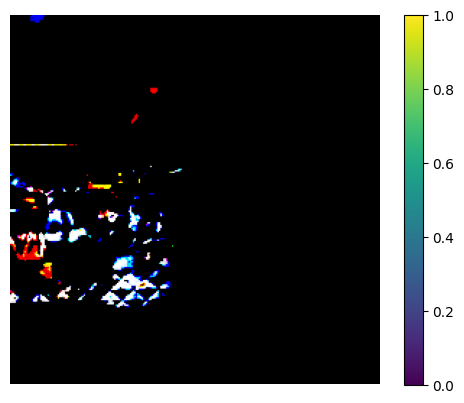

In [50]:
display_pixel_wise_img_diff(test_batch[9+test_ix], generated_test_data[9+test_ix], threshold=0.8, channel=0, verbose=1)

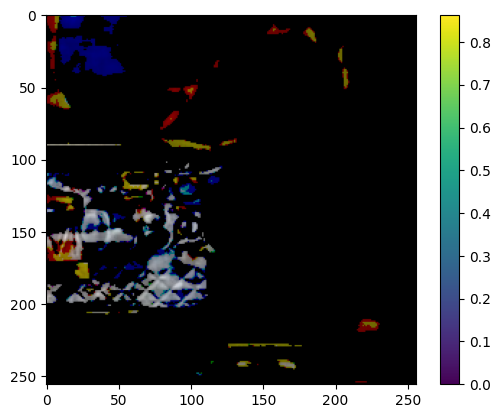

In [51]:
THRESHOLD = 0.4

residuals = np.abs(test_batch[9+test_ix] - generated_test_data[9+test_ix])

residuals[residuals < THRESHOLD] = 0
plt.imshow(residuals.reshape((256, 256, 3)), cmap='viridis')
plt.colorbar()
plt.show()

In [144]:
def visualize_feature_heatmap(model, input_image, conv_layer_name, loss="mae", pool="max"):
    image = tf.expand_dims(input_image, axis=0)
    generated_image = model.predict(image)

    gradModel = tf.keras.Model(inputs=[model.inputs], outputs= [model.get_layer(conv_layer_name).output, model.output])

    for layer in gradModel.layers:
        layer.trainable=False

    conv2d_block_layer_out, recons_layer_out = gradModel(image)
    conv2d_block_layer_out_gen, recons_layer_out_gen = gradModel(generated_image)

    if loss == "mse":
        conv2d_block_layer_diff = tf.square(conv2d_block_layer_out_gen - conv2d_block_layer_out)
    elif loss == "mae":
        conv2d_block_layer_diff = conv2d_block_layer_out - conv2d_block_layer_out_gen

    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(conv2d_block_layer_diff)
    mean_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(conv2d_block_layer_diff)

    '''
    if pool == "max":
        upsample_pool = tf.keras.layers.UpSampling2D(size=(256//max_pool.shape[1]))(max_pool)
    elif pool == "avg":
        upsample_pool = tf.keras.layers.UpSampling2D(size=(256//mean_pool.shape[1]))(mean_pool)
    elif pool == "max+avg":
        upsample_pool = tf.keras.layers.UpSampling2D(size=(256//mean_pool.shape[1]))(max_pool + mean_pool)

    upsample_pool_vis = tf.squeeze(upsample_pool, axis=0)
    '''

    max_pool = tf.keras.layers.UpSampling2D(size=(256//max_pool.shape[1]))(max_pool)
    mean_pool = tf.keras.layers.UpSampling2D(size=(256//mean_pool.shape[1]))(mean_pool)
    max_mean_pool = tf.keras.layers.UpSampling2D(size=(256//mean_pool.shape[1]))(max_pool + mean_pool)

    fig = plt.figure(figsize=(10,10))

    plt.subplot(1,3,1)
    plt.imshow(tf.squeeze(max_pool, axis=0), cmap='jet')
    plt.axis('off')
    plt.title('Max')
    plt.subplot(1,3,2)
    plt.imshow(tf.squeeze(mean_pool, axis=0), cmap='jet')
    plt.title('Avg')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(tf.squeeze(max_mean_pool, axis=0), cmap='jet')
    plt.axis('off')
    plt.title('Max + Avg')

    plt.show()

1/1 [==============================] - 0s 182ms/step


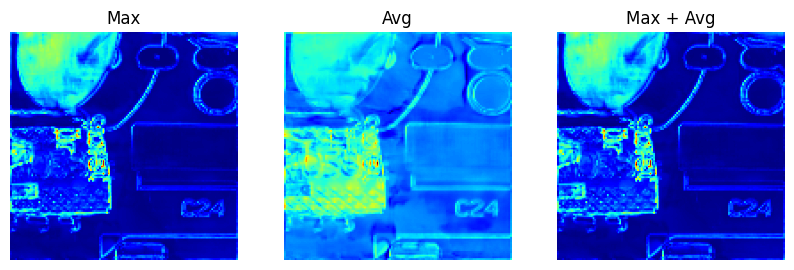

In [145]:
visualize_feature_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_block_0", pool="max+avg")

1/1 [==============================] - 0s 118ms/step


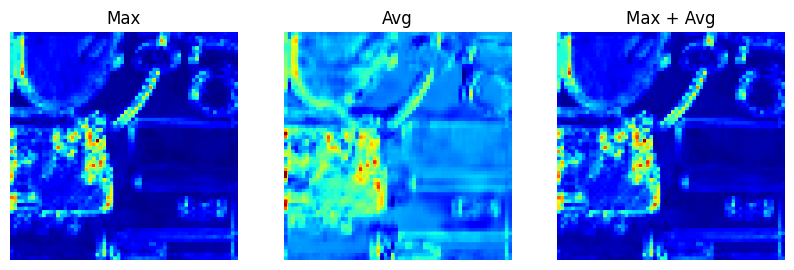

In [120]:
visualize_feature_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_block_1", pool="max+avg")

1/1 [==============================] - 0s 113ms/step


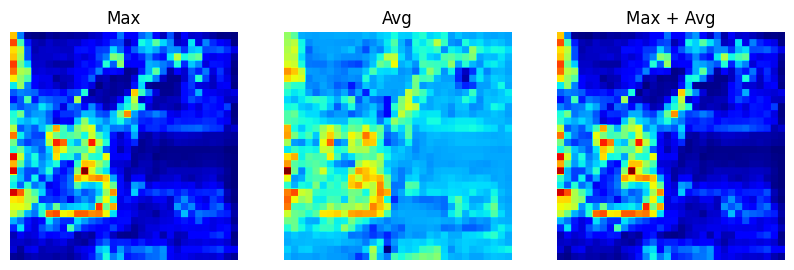

In [121]:
visualize_feature_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="cbam_2", pool="max")

1/1 [==============================] - 0s 203ms/step


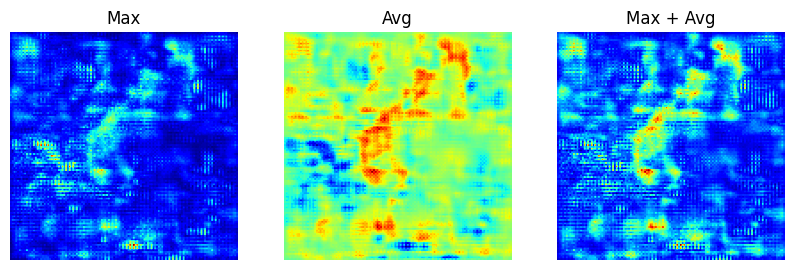

In [122]:
visualize_feature_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_transpose_block_6", pool="max")

1/1 [==============================] - 0s 262ms/step


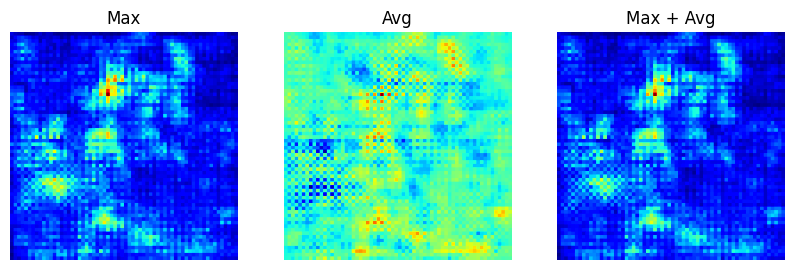

In [123]:
visualize_feature_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_transpose_block_5", pool="max")

1/1 [==============================] - 0s 119ms/step


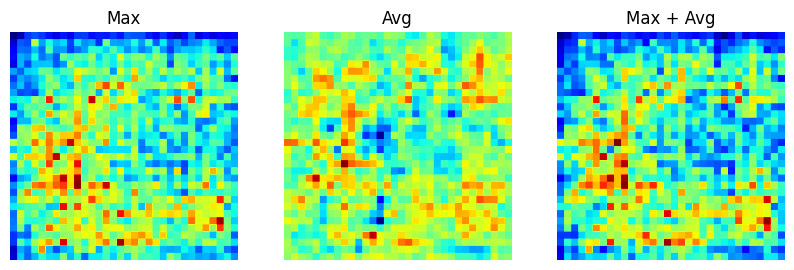

In [124]:
visualize_feature_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_transpose_block_4", pool="max")

1/1 [==============================] - 0s 173ms/step


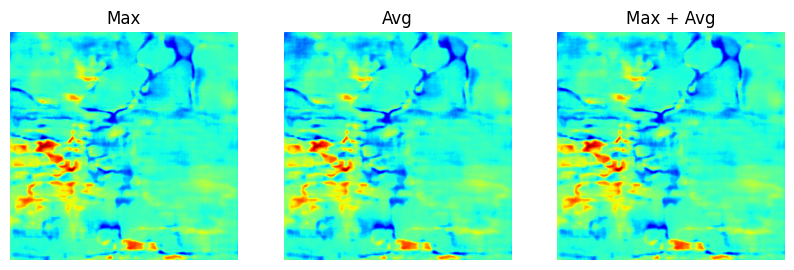

In [125]:
visualize_feature_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_transpose", pool="max")

In [170]:
def visualize_gradient_heatmap(model, input_image, conv_layer_name, loss="mae", pool="max"):
    image = tf.expand_dims(input_image, axis=0)
    generated_image = model.predict(image)

    gradModel = tf.keras.Model(inputs=[model.inputs], outputs= [model.get_layer(conv_layer_name).output, model.output])


    # Gradient calculation operation
    with tf.GradientTape() as tape:
        image = tf.cast(image, tf.float32)  # cast the image tensor to a float-32
        generated_image = tf.cast(generated_image, tf.float32)  # cast the image tensor to a float-32

        conv2d_block_layer_out, recons_layer_out = gradModel(image)
        conv2d_block_layer_out_gen, recons_layer_out_gen = gradModel(generated_image)

        # Compute the feature-wise differences
        if loss == "mse":
            conv2d_block_layer_diff = tf.square(conv2d_block_layer_out_gen - conv2d_block_layer_out)
        elif loss == "mae":
            conv2d_block_layer_diff = conv2d_block_layer_out_gen - conv2d_block_layer_out

    # Compute gradients of the feature differences with respect to the input image
    #gradients = tape.gradient(conv2d_block_layer_diff, image)

    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(conv2d_block_layer_diff)
    mean_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(conv2d_block_layer_diff)

    max_pool = tf.keras.layers.UpSampling2D(size=(256//max_pool.shape[1]))(max_pool)
    mean_pool = tf.keras.layers.UpSampling2D(size=(256//mean_pool.shape[1]))(mean_pool)
    max_mean_pool = tf.keras.layers.UpSampling2D(size=(256//mean_pool.shape[1]))(max_pool + mean_pool)

    fig = plt.figure(figsize=(10,10))

    plt.subplot(1,3,1)
    plt.imshow(tf.squeeze(max_pool, axis=0), cmap='jet')
    plt.axis('off')
    plt.title('Max')
    plt.subplot(1,3,2)
    plt.imshow(tf.squeeze(mean_pool, axis=0), cmap='jet')
    plt.title('Avg')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(tf.squeeze(max_mean_pool, axis=0), cmap='jet')
    plt.axis('off')
    plt.title('Max + Avg')

    plt.show()

1/1 [==============================] - 0s 315ms/step


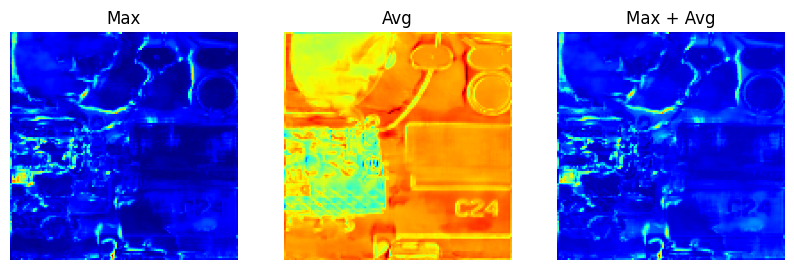

In [171]:
visualize_gradient_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_block_0", pool="max+avg")

1/1 [==============================] - 0s 260ms/step


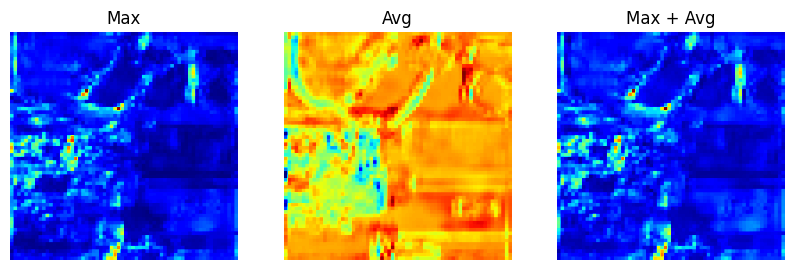

In [172]:
visualize_gradient_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_block_1", pool="max+avg")

1/1 [==============================] - 0s 183ms/step


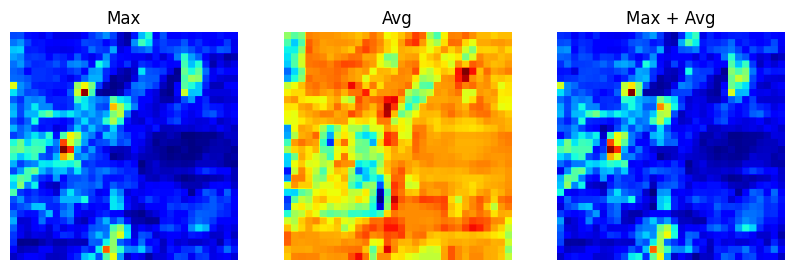

In [173]:
visualize_gradient_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_block_2", pool="max+avg")

1/1 [==============================] - 0s 388ms/step


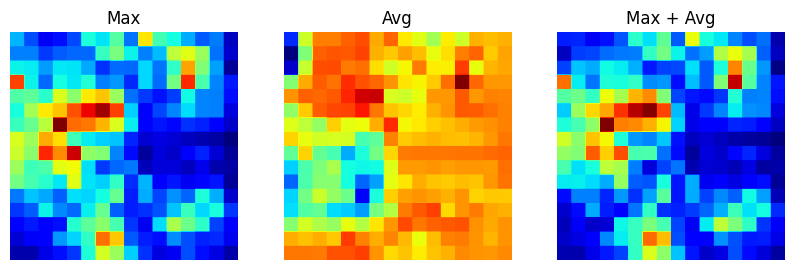

In [174]:
visualize_gradient_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_block_3", pool="max+avg")

1/1 [==============================] - 0s 243ms/step


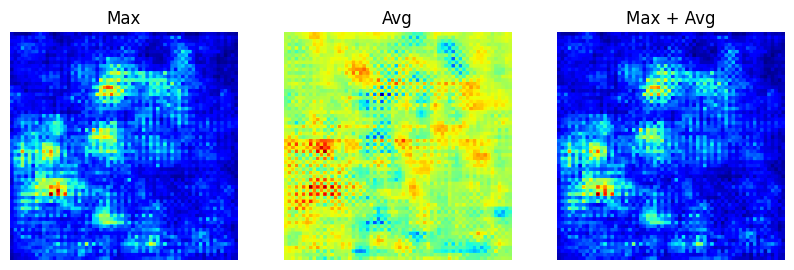

In [177]:
visualize_gradient_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_transpose_block_5", pool="max+avg")

1/1 [==============================] - 0s 202ms/step


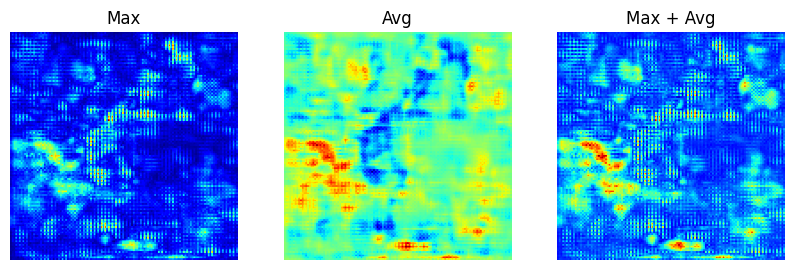

In [178]:
visualize_gradient_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_transpose_block_6", pool="max+avg")

1/1 [==============================] - 0s 228ms/step


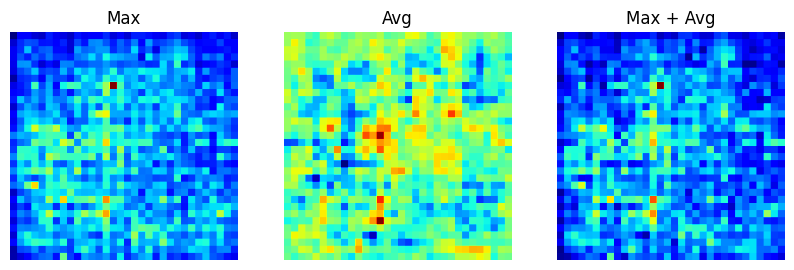

In [179]:
visualize_gradient_heatmap(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_transpose_block_4", pool="max+avg")

In [100]:
'''
def visualize_feature_heatmap(model, input_image, generated_image, conv_layer_name, pool="max"):
    image = tf.expand_dims(input_image, axis=0)
    generated_image = tf.expand_dims(generated_image, axis=0)

    gradModel = tf.keras.Model(inputs=[model.inputs], outputs= [model.get_layer(conv_layer_name).output, model.output])

    for layer in gradModel.layers:
        layer.trainable=False

    with tf.GradientTape() as tape:
        # Set the test sample as input to the autoencoder
        inputs = tf.Variable(image, dtype=tf.float32)
        generated_input = tf.Variable(generated_image, dtype=tf.float32)

        # Forward pass through the autoencoder
        conv2d_block_layer_out, recons_layer_out = gradModel(inputs)
        conv2d_block_layer_out_gen, recons_layer_out_gen = gradModel(generated_input)
        #predictions = model(inputs)

        # Compute the reconstruction loss
        loss = tf.square(conv2d_block_layer_out_gen - conv2d_block_layer_out)
        #loss = tf.keras.losses.mean_squared_error(conv2d_block_layer_out, conv2d_block_layer_out_gen)

    # Use the gradient tape to compute the gradients of the loss with respect to the input
    #gradients = tape.gradient(loss, inputs)
    gradients = tape.gradient(loss, conv2d_block_layer_out)
    #gradients = tf.square(gradients)

    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(gradients)
    mean_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(gradients)

    max_pool = tf.keras.layers.UpSampling2D(size=(256//max_pool.shape[1]))(max_pool)
    mean_pool = tf.keras.layers.UpSampling2D(size=(256//mean_pool.shape[1]))(mean_pool)
    max_mean_pool = tf.keras.layers.UpSampling2D(size=(256//mean_pool.shape[1]))(max_pool + mean_pool)

    fig = plt.figure(figsize=(10,10))

    plt.subplot(1,3,1)
    plt.imshow(tf.squeeze(max_pool, axis=0), cmap='jet')
    plt.axis('off')
    plt.title('Max')
    plt.subplot(1,3,2)
    plt.imshow(tf.squeeze(mean_pool, axis=0), cmap='jet')
    plt.title('Avg')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(tf.squeeze(max_mean_pool, axis=0), cmap='jet')
    plt.axis('off')
    plt.title('Max + Avg')

    plt.show()


visualize_feature_heatmap(custom_model, test_batch[9+test_ix], generated_test_data[9+test_ix], conv_layer_name="cbam_2", pool="max")
'''

In [ ]:
import cv2

def heatmap_visualize(model, input_image, conv_layer_name, trasnpose_conv_layer_name, pool="max"):
    image = tf.expand_dims(input_image, axis=0)
    conv2d_block_layer = model.get_layer(conv_layer_name)
    trasnposed_conv2d_block_layer = model.get_layer(trasnpose_conv_layer_name)

    gradModel = tf.keras.Model(inputs=[model.inputs], outputs= [conv2d_block_layer.output, trasnposed_conv2d_block_layer.output, model.output])
    '''
    for layer in gradModel.layers:
        layer.trainable=False

    conv2d_block_layer_out, trasnposed_conv2d_block_layer_out, _ = gradModel(image)
    '''
    # Compute the gradients
    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)  # cast the image tensor to a float-32
        (conv2d_block_layer_out, trasnposed_conv2d_block_layer_out, preds) = gradModel(inputs)

        #max_pool_conv = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(conv2d_block_layer_out)
        #conv2d_block_layer_out = tf.keras.layers.UpSampling2D(size=(256//max_pool_conv.shape[1]))(max_pool_conv)
        #preds = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(preds)

        loss = tf.keras.losses.mean_squared_error(conv2d_block_layer_out, trasnposed_conv2d_block_layer_out)
        #loss = preds[:, self.class_id]

    # Compute the gradients for last convolutional layer
    grads = tape.gradient(loss, conv2d_block_layer_out)

    # Compute the guided gradients
    cast_conv_layer_output = tf.cast(conv2d_block_layer_out > 0, tf.float32)
    cast_grads = tf.cast(grads > 0, tf.float32)
    guided_grads = cast_conv_layer_output * cast_grads * grads

    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    conv2d_block_layer_out = conv2d_block_layer_out[0]
    guided_grads = guided_grads[0]

    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv2d_block_layer_out), axis=-1)

    # grab the spatial dimensions of the input image and resize the output class
    # activation map to match the input image dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

    # For visualization purpose normalize the heatmap such that
    # all values lie in the range [0, 1], scale the resulting values to the
    # range [0, 255], and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + 1e-8
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")

    # return the resulting heatmap to the calling function
    return heatmap
    '''
    conv2d_block_layer_diff = conv2d_block_layer_out - trasnposed_conv2d_block_layer_out

    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(conv2d_block_layer_diff)
    mean_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(conv2d_block_layer_diff)
    comb_pool = tf.keras.layers.Concatenate(axis=3)([mean_pool, max_pool])

    if pool == "max":
        upsample_pool = tf.keras.layers.UpSampling2D(size=(256//max_pool.shape[1]))(max_pool)
    elif pool == 'avg':
        upsample_pool = tf.keras.layers.UpSampling2D(size=(256//mean_pool.shape[1]))(mean_pool)

    max_pool_vis = tf.squeeze(max_pool, axis=0)
    mean_pool_vis = tf.squeeze(mean_pool, axis=0)
    comb_pool_vis = tf.squeeze(comb_pool, axis=0)
    upsample_pool_vis = tf.squeeze(upsample_pool, axis=0)

    plt.imshow(upsample_pool_vis, cmap='jet')
    return upsample_pool_vis
    '''
    #return grads

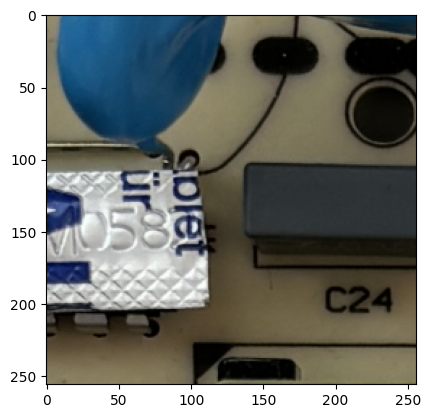

In [ ]:
plt.imshow(test_batch[9+test_ix])

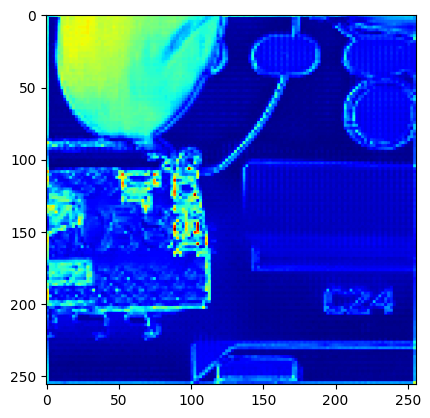

In [ ]:
hm1 = heatmap_visualize(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_block_0", trasnpose_conv_layer_name="conv2d_transpose_block_6", pool="max")
plt.imshow(hm1, cmap="jet")

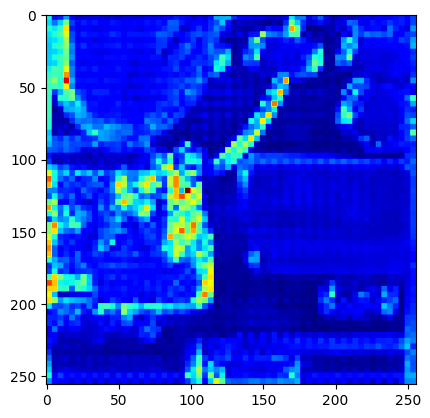

In [ ]:
hm2 = heatmap_visualize(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_block_1", trasnpose_conv_layer_name="conv2d_transpose_block_5", pool="max")
plt.imshow(hm2, cmap="jet")

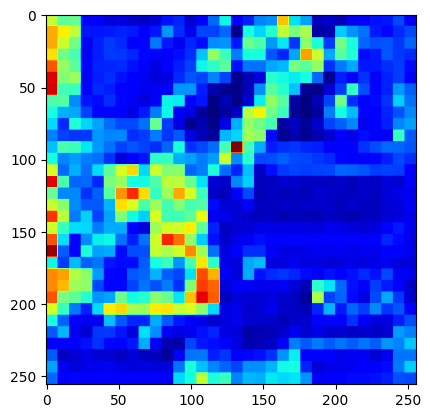

In [ ]:
hm3 = heatmap_visualize(custom_model, test_batch[9+test_ix], conv_layer_name="conv2d_block_2", trasnpose_conv_layer_name="conv2d_transpose_block_4", pool="max")
plt.imshow(hm3, cmap="jet")

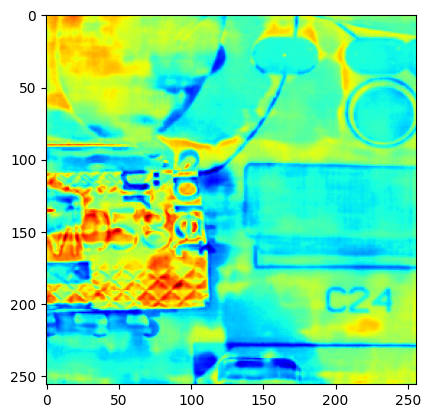

In [ ]:
hm4 = heatmap_visualize(custom_model, test_batch[9+test_ix], conv_layer_name="input_1", trasnpose_conv_layer_name="conv2d_transpose")
plt.imshow(hm4, cmap="jet")

In [ ]:
hm1 = tf.concat((hm1,hm2), axis=2)
hm1 = tf.concat((hm1,hm3), axis=2)
hm1 = tf.concat((hm1,hm4), axis=2)

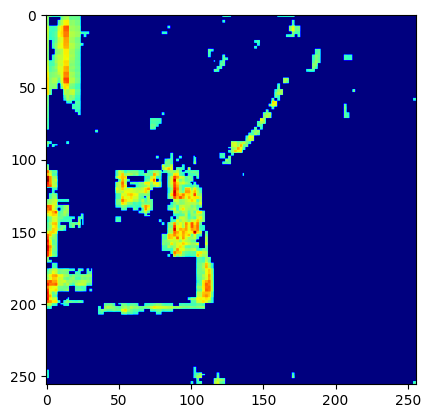

In [ ]:
mean_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(tf.expand_dims(hm1, axis=0))
mean_pool_vis = np.array(tf.squeeze(mean_pool, axis=0))

# Normalize heatmap
numer = mean_pool_vis - np.min(mean_pool_vis)
denom = (mean_pool_vis.max() - mean_pool_vis.min()) + 1e-8
mean_pool_vis = numer / denom

mean_pool_vis[mean_pool_vis < 0.4] = 0.0
plt.imshow(mean_pool_vis, cmap='jet')

In [ ]:
import matplotlib.cm as cm
import matplotlib
import cv2

def overlay_heatmap(heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
  # Use jet colormap to colorize heatmap
  jet = matplotlib.colormaps.get_cmap("jet")  # cm.get_cmap will be deprecated after few releases
  # jet = matplotlib.colormaps.get_cmap("jet")

  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]  # First 3 channel: R, G, B
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
  jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

  # Superimpose/Combine the heatmap on original image
  superimposed_img = jet_heatmap * alpha + image
  superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

  return (heatmap, superimposed_img)

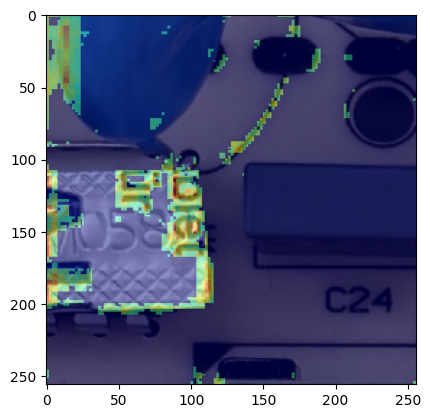

In [ ]:
_, superimposed_img = overlay_heatmap((np.squeeze(mean_pool_vis)*255).astype("uint8"), test_batch[9+test_ix]*255, alpha=0.8)
plt.imshow(superimposed_img)

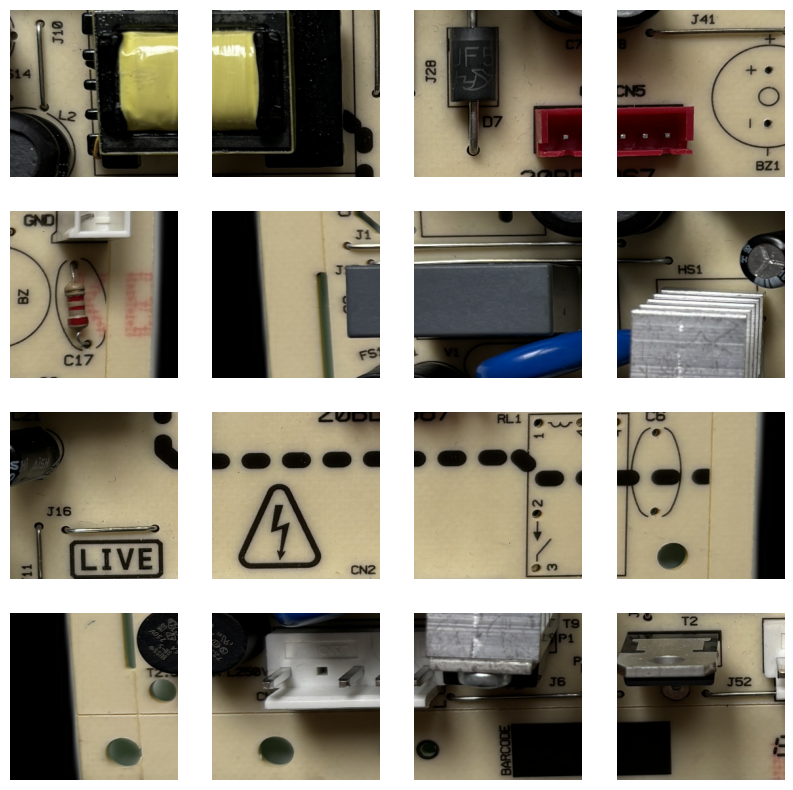

In [ ]:
image_batch = next(iter(test_dataset.skip(36)))

fig = plt.figure(figsize=(10,10))

for index, image in enumerate(image_batch):  # Get first batch
  plt.subplot(4, 4, index + 1)
  plt.imshow(image[:, :, :])
  plt.axis('off')
  if index >= ((4*4)-1):
    break

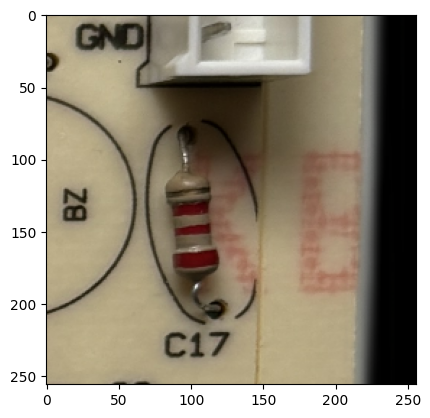

In [ ]:
plt.imshow(image_batch[4])

In [ ]:
test_img_2 = image_batch[4]

In [ ]:
generated_test_img2 = custom_model.predict(tf.expand_dims(test_img_2, axis=0))

1/1 [==============================] - 0s 323ms/step


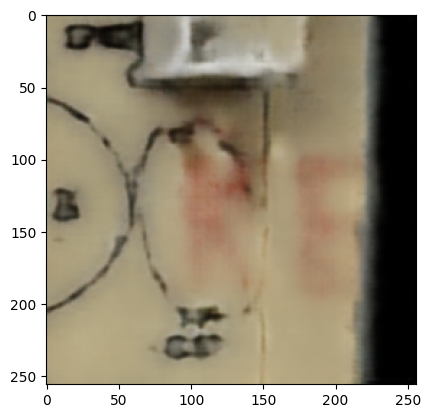

In [ ]:
plt.imshow(tf.squeeze(generated_test_img2))

Difference map shape: (256, 256, 3)
Normalized difference map shape: (256, 256, 3)
Normalized difference map min, avg, max value: (6.258745202103455e-07, 0.12856, 1.0)
Colored difference map shape: (256, 256, 3, 4)


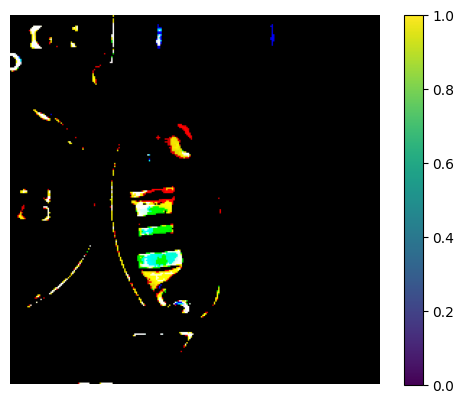

In [ ]:
display_pixel_wise_img_diff(test_img_2, tf.squeeze(generated_test_img2), threshold=0.8, channel=0, verbose=1)

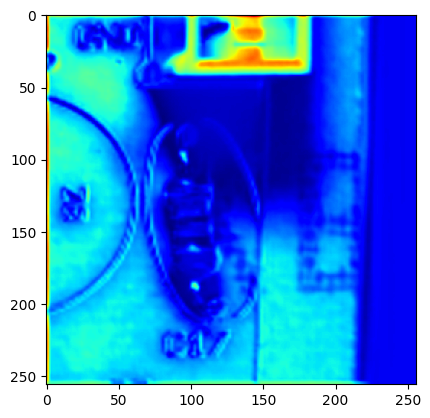

In [ ]:
hm1 = heatmap_visualize(custom_model, test_img_2, conv_layer_name="conv2d_block_0", trasnpose_conv_layer_name="conv2d_transpose_block_6")
plt.imshow(hm1, cmap='jet')

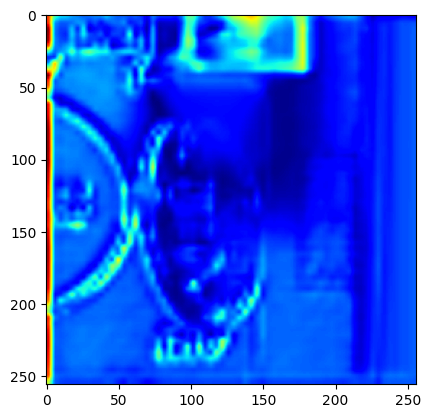

In [ ]:
hm2 = heatmap_visualize(custom_model, test_img_2, conv_layer_name="conv2d_block_1", trasnpose_conv_layer_name="conv2d_transpose_block_5")
plt.imshow(hm2, cmap='jet')

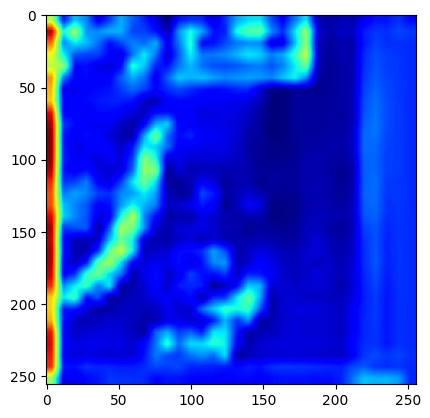

In [ ]:
hm3 = heatmap_visualize(custom_model, test_img_2, conv_layer_name="conv2d_block_2", trasnpose_conv_layer_name="conv2d_transpose_block_4")
plt.imshow(hm3, cmap='jet')

In [ ]:
hm4 = heatmap_visualize(custom_model, test_img_2, conv_layer_name="input_1", trasnpose_conv_layer_name="conv2d_transpose")
plt.imshow(hm4, cmap='jet')

In [ ]:
hm1 = tf.concat((hm1,hm2), axis=2)
hm1 = tf.concat((hm1,hm3), axis=2)
hm1 = tf.concat((hm1,hm4), axis=2)

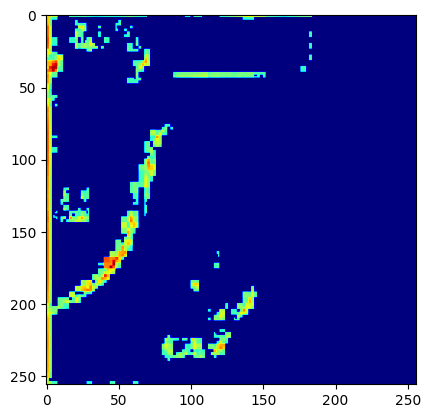

In [ ]:
mean_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(tf.expand_dims(hm1, axis=0))
mean_pool_vis = np.array(tf.squeeze(mean_pool, axis=0))

# Normalize heatmap
numer = mean_pool_vis - np.min(mean_pool_vis)
denom = (mean_pool_vis.max() - mean_pool_vis.min()) + 1e-8
mean_pool_vis = numer / denom

mean_pool_vis[mean_pool_vis < 0.4] = 0.0
plt.imshow(mean_pool_vis, cmap='jet')

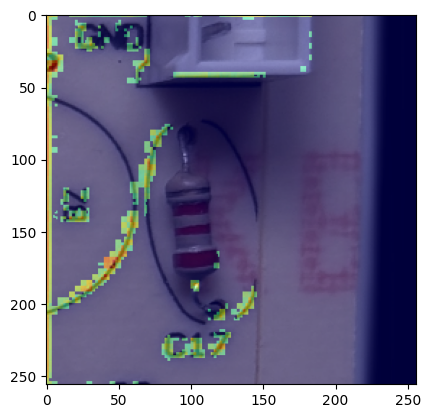

In [ ]:
_, superimposed_img = overlay_heatmap((np.squeeze(mean_pool_vis)*255).astype("uint8"), test_img_2*255, alpha=0.8)
plt.imshow(superimposed_img)

In [ ]:
generated_test_img.shape

(1280, 1792, 3)

In [ ]:
test_img_0 = utils.load_images(test_img_files[20], img_size=(1280, 1792), scl=True)

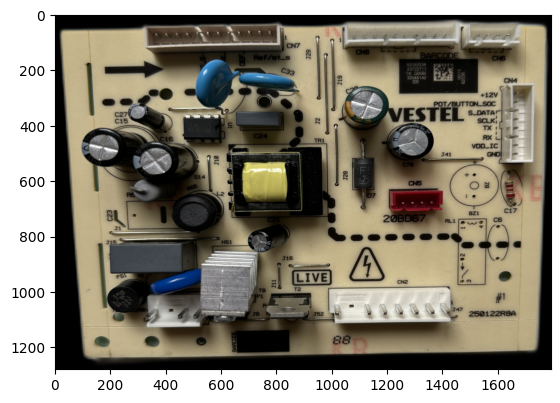

In [ ]:
plt.imshow(test_img_0)

Difference map shape: (1280, 1792, 3)
Normalized difference map shape: (1280, 1792, 3)
Normalized difference map min, avg, max value: (1.8052405792445825e-08, 0.15927, 1.0)
Colored difference map shape: (1280, 1792, 3, 4)


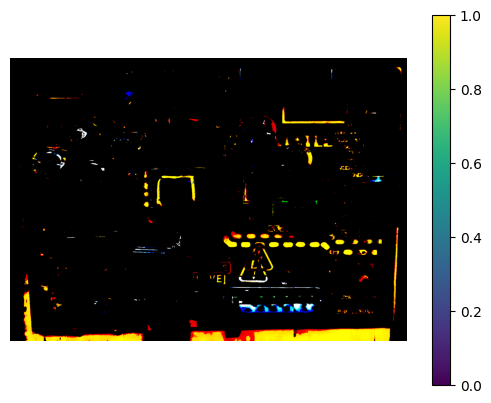

In [ ]:
display_pixel_wise_img_diff(test_img_0, generated_test_img, threshold=0.8, channel=0, verbose=1)